# Geometric factor calculations using Monte Carlo simulation data 
By Andrei R. Hanu - <andrei.hanu@nasa.gov>

## Introduction

The geometric factor ($\bf{G}$, units of cm$^2$ sr) of a particle detector is analogous to the "collecting power" of an optical telescope and is a function of the surface area of the instrument and detection efficiency, which itself is a function of the charge, mass, and energy of the incident particles. If the detector's geometry factor is known, the spatial differential flux ($\bf{\Phi}$, units of particles cm$^{-2}$ sr$^{-1}$ sec$^{-1}$) incident on the detector can be calculated from the counting rate ($\bf{N_D}$, units of particles $sec^{-1}$). So very simply, the geometric factor is defined as the counts received by a detector per unit time divided by the spatial differential flux around the instrument.

$$ G = \frac{N_D}{J} $$

** Note: For radiation risk assesment calculations, the flux is typically measured in energy bins with units of particles cm$^{-2}$ sr$^{-1}$ sec$^{-1}$ MeV$^{-1}$ **

Tradiationally, a detector's geometric factor has usually been estimated by approximation, however, only a few analytical solutions exist for simple source and detector geometries - see Sullivan (1971). For more complicated detector geometries, including electronic coincidence/anti-coincidence logic, an analytical solution might be difficult, or even impossible, to derive in the closed form. In such cases, the Monte Carlo technique is employed to compute the geometrical factor, see Crannell et al. (1971), by surrounded the detector geometry with a spherical source and assuming an isotropic radiation environment. Although, you can also apply this technique to anisotropic radiation environments. 

## Isotropic Radiation



## Source Normalization

For isotropic radiation environments, the number of particles $\bf{N_R}$ traversing a sphere is determined by the integrating the spatial differential flux over the surface area of the sphere and solid angle.

$$ N_R = \int_{\Omega}\int_{S} JdSd\Omega $$

Where the differential surface area ($\bf{dS}$) and differential solid angle ($\bf{d\Omega}$) in spherical coordinates is:

$$ dS = R^2 sin \theta d\theta d\phi $$

$$ d\Omega = sin \theta d\theta d\phi $$

Working through the integral, we see that the number of particles $\bf{N_R}$ traversing a sphere is:

$$ N_R = 4 \pi^2 R^2 J $$

And it depends on:

- The radius (ie. bigger sphere == more particles crossing the sphere)
- The spatial differential flux (ie. more flux == more particles crossing the sphere)

Finally, by using Eq.1 and Eq. 5 the geometric factor for an isotropic radiation environments can be written as follows:

$$ G = \frac{N_D}{N_R}4 \pi^2 R^2 $$

Where:

- $N_D$ is the number of particles interacting with the detector model
- $N_R$ is the total number of simulated particles
- $R$ is the radius of the spherical source encircling the detector model

The associated standard deviation ($\bf{\sigma_G}$) is obtained from the binomial distribution and follows:

$$ \sigma_G = 4\pi^2R^2 \sqrt{\left(1-\frac{N_D}{N_R}\right)\frac{N_D}{N_R^2}} $$

## Monte Carlo method

To calculate the geometric factor of a detector using the Monte Carlo method, the following steps need to be taken:

- The detector geometry, or a simplified model, should be implemented in your favourite Monte Carlo particle transport  code (Geant4, MCNP, FLUKA, EGS, etc)

If an isotropic flux, typical of space-borne instruments, is assumed:

- The detector geometry is enveloped by a spherical source such that the spectral, spatial, and angular distribution of primary particles can be specified

- The primary particles must be uniformly distributed over the entire surface of spherical source
- The angular distribution for the emission of primary particles must follow a cosine-law distribution

## References

+ Sullivan, J. D. "Geometric factor and directional response of single and multi-element particle telescopes." Nuclear Instruments and methods 95.1 (1971): 5-11.

+ Crannell, C. J., and J. F. Ormes. "Geometrical-factor determination using a monte carlo approach." Nuclear Instruments and Methods 94.1 (1971): 179-183.

+ Sanderson, T. R., and D. E. Page. "Geometrical aspects of the performance of cosmic ray detector telescopes in non-isotropic particle distributions." Nuclear Instruments and Methods 104.3 (1972): 493-504.


In [1]:
# Matplotlib - 2D plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams

# Show matplotlib figures inline the notebook
%matplotlib inline

# Pandas - High-performance data analysis
import pandas

# Glob - Unix style pathname pattern expansion
# Used to aggregate folders and files into a single list so they can be iterated over
import glob

# Numpy - For handling of large, multi-dimensional arrays and matrices
import numpy as np
from numpy.linalg import solve

# Scipy - For accurate integration
from scipy.integrate import simps
from scipy.integrate import trapz
from scipy.optimize import curve_fit
import scipy.odr as sc

##########################################################################################
# Setting rcParams for publication quality graphs
fig_width_pt = 246.0                    # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # Width in inches
fig_height = fig_width*golden_mean      # Height in inches
fig_size =  [fig_width, fig_height]
# fig_size =  [fig_height,fig_width]
fig_size =  [7.3,4.2]
# fig_size =  [4.2,7.3]
# fig_size =  [7.3*1.5,4.2*1.5]
# fig_size =  [7.3*2,4.2*2]
params = {'backend': 'pdf',
        'axes.labelsize': 11,
        'legend.fontsize': 9,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'xtick.major.size': 6,
        'xtick.major.width': 1,
        'xtick.minor.size': 2.5,
        'xtick.minor.width': 1,
        'ytick.major.size': 6,
        'ytick.major.width': 1,
        'ytick.minor.size': 2.5,
        'ytick.minor.width': 1,
        'font.family': 'times-new-roman',
        'font.sans-serif': 'Times New Roman',
        'font.size': 10,
        'text.usetex': True,
        'figure.figsize': fig_size}

# Update rcParams
rcParams.update(params)

In [2]:
##########################################################################################
# Energy of incident (input) particles
InputEnergies = np.array([#np.linspace(10,90, num=9, endpoint=True, dtype = int),
                          #np.linspace(100,900, num=9, endpoint=True, dtype = int),
                          np.linspace(1100,1900, num=9, endpoint=True, dtype = int),
                          np.linspace(1000,9000, num=9, endpoint=True, dtype = int),
                          np.linspace(10000,90000, num=9, endpoint=True, dtype = int),
                          np.linspace(100000,900000, num=9, endpoint=True, dtype = int),
                            ]).flatten()

# Arrange the array into the proper order
InputEnergies = np.delete(InputEnergies,9)
InputEnergies = np.insert(InputEnergies, [0], [1000])
InputEnergies = np.insert(InputEnergies, [36], [1000000])
# InputEnergies = np.delete(InputEnergies,18)
# InputEnergies = np.insert(InputEnergies, [9], [1000])
# InputEnergies = np.insert(InputEnergies, [45], [1000000])
# InputEnergies = np.delete(InputEnergies,27)
# InputEnergies = np.insert(InputEnergies, [18], [1000])
# InputEnergies = np.insert(InputEnergies, [54], [1000000])
# ##########################################################################################
# Energy thresholds (in eV) for events that will be included in the analysis
Thr_Gas = 100.
print InputEnergies

[   1000    1100    1200    1300    1400    1500    1600    1700    1800
    1900    2000    3000    4000    5000    6000    7000    8000    9000
   10000   20000   30000   40000   50000   60000   70000   80000   90000
  100000  200000  300000  400000  500000  600000  700000  800000  900000
 1000000]


In [3]:
##########################################################################################
# Import Data for use by the program.
# This data is generated by the file G4AdEPTCubeSat-DataProcessing

GammaData = '../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_Data/gamma_4U_Data.csv'
DataFolder = '../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/'
Data = pandas.read_csv(GammaData, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13], comment="#", error_bad_lines=False, skip_blank_lines=True).values
# Columns for np array Data
# Column 0: Incident photon energy
# Column 1: Number of Positrons which deposited energy
# Column 2: Number of Electrons which deposited energy
# Column 3: Number of Positron energy depositions below threshold
# Column 4: Number of Electron energy depositions below threshold
# Column 5: Number of total events which deposited energy above threshold
# Column 6: Number of total events below threshold
# Column 7: Number of Compton Scattering events
# Column 8: Number of Pair Production events
# Column 9: Number of Photoelectric events
# Column 10: Number of Triton creation events

In [4]:
##########################################################################################
# Calculate the geometry factor (G) assuming an isotropic radiation environment.
# The detector is centered on, and encircled by, a spherical source of radius (R) and
# with N_R simulated particles distributed uniformly along the inner surface.
# Everything with the suffix _2 is from the group which had 1 000 000 000 photons

# Source information (Get this from the Geant4 simulation!!)
# Energies 1.1 - 1.9 MeV have 1 000 000 000 photons simulated
N_R = 100000000.
N_R_2 = 100000000.
# N_R_2 = 1000000000.
R = 17.0


# # Calculate the geometry factors
# G_Pair_1 = Data[0:10,8]/N_R*4*(np.pi**2)*(R**2)
# G_Total_1 = Data[0:10,5]/N_R*4*(np.pi**2)*(R**2)

# G_Pair_2 = Data[10:19,8]/N_R_2*4*(np.pi**2)*(R**2)
# G_Total_2 = Data[10:19,5]/N_R_2*4*(np.pi**2)*(R**2)

# G_Pair_3 = Data[19:,8]/N_R*4*(np.pi**2)*(R**2)
# G_Total_3 = Data[19:,5]/N_R*4*(np.pi**2)*(R**2)

# G_Pair = np.ndarray([])
# G_Pair_temp = np.ndarray([])
# G_Pair_temp = np.append(G_Pair_1,G_Pair_2)
# G_Pair = np.append(G_Pair_temp,G_Pair_3)

# G_Total = np.ndarray([])
# G_Total_temp = np.ndarray([])
# G_Total_temp = np.append(G_Total_1,G_Total_2)
# G_Total = np.append(G_Total_temp,G_Total_3)

# # Calculate the errors for geometry factors 
# err_G_Pair_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:10,8]/N_R)*Data[0:10,8]/N_R**2)
# err_G_Total_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:10,5]/N_R)*Data[0:10,5]/N_R**2)

# err_G_Pair_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[10:19,8]/N_R_2)*Data[10:19,8]/N_R_2**2)
# err_G_Total_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[10:19,5]/N_R_2)*Data[10:19,5]/N_R_2**2)

# err_G_Pair_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:,8]/N_R)*Data[19:,8]/N_R**2)
# err_G_Total_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:,5]/N_R)*Data[19:,5]/N_R**2)


# err_G_Pair = np.array([])
# err_G_Pair_temp = np.array([])
# err_G_Pair_temp = np.append(err_G_Pair_1,err_G_Pair_2)
# err_G_Pair = np.append(err_G_Pair_temp,err_G_Pair_3)

# err_G_Total = np.array([])
# err_G_Total_temp = np.array([])
# err_G_Total_temp = np.append(err_G_Pair_1,err_G_Pair_2)
# err_G_Total = np.append(err_G_Total_temp,err_G_Total_3)

# # Calculate relative errors for the geometry factors
# relErr_G_Total = err_G_Total/G_Total
# relErr_G_Pair = err_G_Pair/G_Pair


# Calculate the geometry factors
G_Pair_1 = Data[0:19,8]/N_R*4*(np.pi**2)*(R**2)
G_Total_1 = Data[0:19,5]/N_R*4*(np.pi**2)*(R**2)

G_Pair_2 = Data[19:28,8]/N_R_2*4*(np.pi**2)*(R**2)
G_Total_2 = Data[19:28,5]/N_R_2*4*(np.pi**2)*(R**2)

G_Pair_3 = Data[28:,8]/N_R*4*(np.pi**2)*(R**2)
G_Total_3 = Data[28:,5]/N_R*4*(np.pi**2)*(R**2)

G_Pair = np.ndarray([])
G_Pair_temp = np.ndarray([])
G_Pair_temp = np.append(G_Pair_1,G_Pair_2)
G_Pair = np.append(G_Pair_temp,G_Pair_3)

G_Total = np.ndarray([])
G_Total_temp = np.ndarray([])
G_Total_temp = np.append(G_Total_1,G_Total_2)
G_Total = np.append(G_Total_temp,G_Total_3)

# Calculate the errors for geometry factors 
err_G_Pair_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:19,8]/N_R)*Data[0:19,8]/N_R**2)
err_G_Total_1 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[0:19,5]/N_R)*Data[0:19,5]/N_R**2)

err_G_Pair_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:28,8]/N_R_2)*Data[19:28,8]/N_R_2**2)
err_G_Total_2 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[19:28,5]/N_R_2)*Data[19:28,5]/N_R_2**2)

err_G_Pair_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[28:,8]/N_R)*Data[28:,8]/N_R**2)
err_G_Total_3 = 4*(np.pi**2)*(R**2)*np.sqrt((1-Data[28:,5]/N_R)*Data[28:,5]/N_R**2)

err_G_Pair = np.array([])
err_G_Pair_temp = np.array([])
err_G_Pair_temp = np.append(err_G_Pair_1,err_G_Pair_2)
err_G_Pair = np.append(err_G_Pair_temp,err_G_Pair_3)

err_G_Total = np.array([])
err_G_Total_temp = np.array([])
err_G_Total_temp = np.append(err_G_Pair_1,err_G_Pair_2)
err_G_Total = np.append(err_G_Total_temp,err_G_Total_3)

# Calculate relative errors for the geometry factors
relErr_G_Total = err_G_Total/G_Total
relErr_G_Pair = err_G_Pair/G_Pair

# Calculate average errors
avgErr100 = np.mean(G_Pair[36:])*np.sqrt(sum((relErr_G_Pair[36:])**2))
avgErr5 = np.mean(G_Pair[22:])*np.sqrt(sum((relErr_G_Pair[22:])**2))
avgErr = np.mean(G_Pair[19:])*np.sqrt(sum((relErr_G_Pair[19:])**2))

# Print results
print InputEnergies[36], InputEnergies[22]
print "Average G above 100 MeV:",np.mean(G_Pair[36:]),"+/-",avgErr100
print "Average G above 5 MeV:",np.mean(G_Pair[22:]),"+/-",avgErr5
print "Total average G:",np.mean(G_Pair[:]),"+/-",avgErr

print G_Pair

1000000 50000
Average G above 100 MeV: 3.82643852019 +/- 0.0208907157855
Average G above 5 MeV: 3.24223102735 +/- 0.0755291698456
Total average G: 1.63625478297 +/- 0.0812611375453
[  0.00000000e+00   1.02683364e-03   2.62413042e-03   7.18783549e-03
   1.72279867e-02   2.29326180e-02   3.03486387e-02   4.39256613e-02
   5.77308692e-02   6.91401319e-02   9.20727499e-02   2.48836019e-01
   4.19404496e-01   5.57228390e-01   6.98589154e-01   7.97621554e-01
   9.17418813e-01   9.91008557e-01   1.09563150e+00   1.65126259e+00
   1.98064800e+00   2.20609503e+00   2.34814035e+00   2.51220555e+00
   2.58408391e+00   2.74746455e+00   2.80667862e+00   2.88403342e+00
   3.24582114e+00   3.42540294e+00   3.57417972e+00   3.66545382e+00
   3.67766173e+00   3.75729839e+00   3.75832522e+00   3.82027752e+00
   3.82643852e+00]


Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/Geometric_Factor_Gamma_4U.pdf
3.82643852019


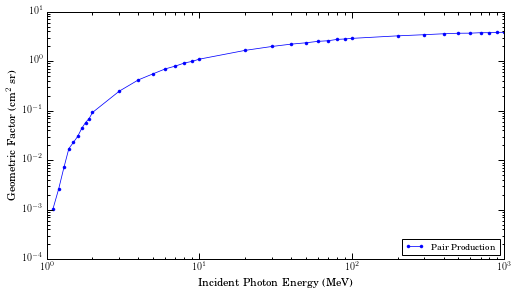

In [20]:
##########################################################################################
# Plot the Geometry Factor over a range of particle energies
G_Total[0]= 1e-6

figG, axG = plt.subplots(1,1)
dropOff = [1e-6, 9.56467310e0]

# plt.loglog(Data[1:,0]/1000., G_Total[1:], 'kx-', linewidth=0.75, label='All Interactions')
# plt.loglog(Data[0:2,0]/1000., dropOff, 'kx--', linewidth=0.75)
plt.loglog(Data[:,0]/1000., G_Pair, 'b.-', linewidth=0.75, label="Pair Production")

# Figure Properties
axG.set_ylabel(r'Geometric Factor (cm$^2$ sr)')  
axG.set_xlabel('Incident Photon Energy (MeV)') 
axG.set_ylim(1e-4, 1e1)
# axG.set_xlim(1e-2, 1000)

# axG.legend(loc='lower right')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figG = 'Geometric_Factor_Gamma_4U.pdf'
plt.savefig(DataFolder + file_figG, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figG)


print max(G_Pair)
# Show the figure
plt.show(figG)

In [6]:
##########################################################################################
# Calculate the differential Extra Glactic Diffuse Emission Gamma-ray flux spectrum
Energies_MeV = InputEnergies/1000.
ETFlux = 40.*10**(-4)*(Energies_MeV**(-2.15))

# figF, axF = plt.subplots(1,1)

# plt.loglog(Energies_MeV,ETFlux, 'b.-')

# # Figure Properties
# axF.set_ylabel(r'Differential Gamma-ray Flux (ph s$^{-1}$ cm$^{-2}$ sr$^{-1}$ MeV$^{-1}$)')  
# axF.set_xlabel('Incident Photon Energy (MeV)') 
# # axF.set_ylim(10**-9, 10**-2)
# # axF.set_xlim(1, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figF = 'Gamma_Flux.pdf'
# plt.savefig(DataFolder + file_figF, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figF)

# # Show the figure
# plt.show(figF)

In [7]:
##########################################################################################
# Compute the Differential and Integral Count Rates for Extragalactic Diffuse

diffCountRate = G_Pair*ETFlux  # Differential count rate
intCountRate_trial = simps(diffCountRate)    # Simple Simpson's rule for calculating integral count rate

###################
# Simspn's/trapezoidal

Counts = 0
dE = 0
intCountRate_trial_2 = np.array([])

for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRate[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRate_trial_2 = np.append(intCountRate_trial_2,Counts)
    
intCountRate_trial2 = sum(intCountRate_trial_2)

###################
# Average energy method

def effEnergy(Energy1,Energy2):
    effEnergy1 = np.log(Energy2/Energy1)/(1./Energy1-1./Energy2)
    effEnergy2 = 1./((effEnergy1**2)*(1./Energy1-1./Energy2))
    return effEnergy1,effEnergy2    # effEnergy1 = 1./(<E>^2 * (1/E1 - 1/E2))

counts = 0
inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

[effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

diffCountRate1 = diffCountRate[0:len(effecEnergy2)]/effecEnergy2
diffCountRate2 = diffCountRate[0:len(effecEnergy1)]*effecEnergy1

revDiffCountRate1 = diffCountRate1[::-1]
revDiffCountRate2 = diffCountRate2[::-1]

intCountRate1 = np.array([])
intCountRate2 = np.array([])

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRate1[0:i])
    intCountRate1 = np.append(intCountRate1, counts)

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRate2[0:i])
    intCountRate2 = np.append(intCountRate2, counts)
    
intCountRate1 = intCountRate1[::-1]
intCountRate2 = intCountRate2[::-1]

##########################################################################################
# Calculate the count rate error from Simpson's Method
low_G_Pair = G_Pair - err_G_Pair
high_G_Pair = G_Pair + err_G_Pair
diffCountRateErrorLow = low_G_Pair*ETFlux
diffCountRateErrorHigh = high_G_Pair*ETFlux

# Lowest possible counts
Counts = 0
dE = 0
intCountRateErrorLow = np.array([])

for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRateErrorLow[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRateErrorLow = np.append(intCountRateErrorLow,Counts)

intCountRateErrorLow = sum(intCountRateErrorLow)    
    
# Highest possible counts
Counts = 0
dE = 0
intCountRateErrorHigh = np.array([])

for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRateErrorHigh[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRateErrorHigh = np.append(intCountRateErrorHigh,Counts)
    
intCountRateErrorHigh = sum(intCountRateErrorHigh)

intCountRateError = (intCountRateErrorHigh-intCountRateErrorLow)/2

##########################################################################################
# Calculate the count rate error from Average Energy Method

counts = 0
inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

[effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

# Lowest possible count rate
diffCountRateErrorAvgLow = diffCountRateErrorLow[0:len(effecEnergy2)]/effecEnergy2
revDiffCountRateErrorAvgLow = diffCountRateErrorAvgLow[::-1]
intCountRateErrorAvgLow = np.array([])

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRateErrorAvgLow[0:i])
    intCountRateErrorAvgLow = np.append(intCountRateErrorAvgLow, counts)
    
intCountRateErrorAvgLow = intCountRateErrorAvgLow[::-1]

# Highest Possible count rate
diffCountRateErrorAvgHigh = diffCountRateErrorHigh[0:len(effecEnergy2)]/effecEnergy2
revDiffCountRateErrorAvgHigh = diffCountRateErrorAvgHigh[::-1]
intCountRateErrorAvgHigh = np.array([])

for i in range(0,len(diffCountRate)):
    counts = sum(revDiffCountRateErrorAvgHigh[0:i])
    intCountRateErrorAvgHigh = np.append(intCountRateErrorAvgHigh, counts)
    
intCountRateErrorAvgHigh = intCountRateErrorAvgHigh[::-1]


intCountRateErrorAvg = (max(intCountRateErrorAvgHigh)-max(intCountRateErrorAvgLow))/2

# ##########################################################################################
# # Plot the differential count rate
# figD, axD = plt.subplots(1,1)
# plt.loglog(Energies_MeV,diffCountRate,'b-')

# axD.set_ylabel(r'Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
# axD.set_xlabel('Incident Photon Energy (MeV)')
# # axD.set_ylim(1e-9, 1e-4)
# # axD.set_xlim(1, 1000)

# plt.tight_layout()

# file_figD = 'Differential_Count_Rate.pdf'
# plt.savefig(DataFolder + file_figD, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figD)

# plt.show(figD)

# ##########################################################################################
# # Plot the Integral Count Rate
# figI, axI = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)],intCountRate1,'b-')

# # Figure Properties
# axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$) with Energy $>$ E')  
# axI.set_xlabel('Incident Photon Energy (MeV)') 
# # axI.set_ylim(1e-7, 1e-3)
# # axI.set_xlim(1e-2, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figI = 'Integral_Count_Rate.pdf'
# plt.savefig(DataFolder + file_figI, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figI)

# Show the figure

# ##########################################################################################
# # Plot the Integral Count Rate
# print len(effecEnergy2), len(Energies_MeV)
# figInt, axInt = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)-1],effecEnergy2,'b.-')

# # Figure Properties
# # axInt.set_ylabel(r'Integral Count Rate (ph s$^{-1}$)')  
# # axInt.set_xlabel('Incident Photon Energy (MeV)') 
# # axI.set_ylim(1e-7, 1e-3)
# # axI.set_xlim(1e-2, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figInt = 'Effective_Energy_2.pdf'
# plt.savefig(DataFolder + file_figInt, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figInt)

# # Show the figure
# plt.show(figInt)

# ##########################################################################################
# # Plot the Integral Count Rate
# figInt2, axInt2 = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)-1],effecEnergy1,'b.-')

# # Figure Properties
# # axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$)')  
# # axI.set_xlabel('Incident Photon Energy (MeV)') 
# # axI.set_ylim(1e-7, 1e-3)
# # axI.set_xlim(1e-2, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figInt2 = 'Effective_Energy_1.pdf'
# plt.savefig(DataFolder + file_figInt2, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figInt2)

# # Show the figure
# plt.show(figInt2)

print InputEnergies[27]/1000., intCountRate1[27]

print "Predicted count rate of", max(intCountRate1)*60*92.6318, "+/- ", intCountRateErrorAvg*60*92.6318, "counts/orbit by Average Energy Method."
print "Predicted count rate of", intCountRate_trial2*60*92.6318," +/- ", intCountRateError*60*92.6318, "counts/orbit by Modified Simpson's Rule."
print "Predicted count rate of", max(intCountRate1)*60*60*24*365," +/- ", intCountRateErrorAvg*60*60*24*365, "counts/year by Average Energy Method."
print "Predicted count rate of", intCountRate_trial2*60*60*24*365, " +/- ", intCountRateError*60*60*24*365, "counts/year by Modified Simpson's Rule."

100.0 8.66195298891e-05
Predicted count rate of 6.57838926035 +/-  0.0949115800798 counts/orbit by Average Energy Method.
Predicted count rate of 5.55908143621  +/-  0.080020740512 counts/orbit by Modified Simpson's Rule.
Predicted count rate of 37326.2896245  +/-  538.535648557 counts/year by Average Energy Method.
Predicted count rate of 31542.6581679  +/-  454.043872764 counts/year by Modified Simpson's Rule.


Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/Geometric_Factor_Error_Gamma.pdf


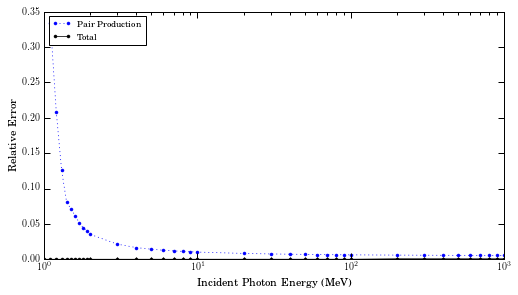

In [8]:
##########################################################################################
# Plot the error in the Geometry Factor over a range of particle energies
figE, axE = plt.subplots(1,1)

plt.semilogx(Data[:,0]/1000., relErr_G_Pair, 'b.:', linewidth=0.75, label="Pair Production")
plt.semilogx(Data[:,0]/1000., relErr_G_Total, 'k.-', linewidth=0.75, label="Total")

# Figure Properties
axE.set_ylabel(r'Relative Error')  
axE.set_xlabel('Incident Photon Energy (MeV)') 
# axE.set_ylim(0., 0.05)
# axE.set_xlim(0.1, 1001)

axE.legend(loc='upper left')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figE = 'Geometric_Factor_Error_Gamma.pdf'
plt.savefig(DataFolder + file_figE, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figE)

# Show the figure
plt.show(figE)

In [9]:
# ##########################################################################################
# # Plot the electron and positron energy deposition
# figE, axE = plt.subplots(1,1)

# # electronEnergy_1 = Data[0:19,12]/N_R
# # positronEnergy_1 = Data[0:19,11]/N_R

# # electronEnergy_2 = Data[19:28,12]/N_R_2
# # positronEnergy_2 = Data[19:28,11]/N_R_2

# # electronEnergy_3 = Data[28:,12]/N_R
# # positronEnergy_3 = Data[28:,11]/N_R

# electronEnergy_1 = Data[0:19,12]/Data[0:19,2]
# positronEnergy_1 = Data[0:19,11]/Data[0:19,1]

# electronEnergy_2 = Data[19:28,12]/Data[19:28,2]
# positronEnergy_2 = Data[19:28,11]/Data[19:28,1]

# electronEnergy_3 = Data[28:,12]/Data[28:,2]
# positronEnergy_3 = Data[28:,11]/Data[28:,1]

# electronEnergy = np.ndarray([])
# electronEnergy_temp = np.ndarray([])
# electronEnergy_temp = np.append(electronEnergy_1,electronEnergy_2)
# electronEnergy = np.append(electronEnergy_temp,electronEnergy_3)

# positronEnergy = np.ndarray([])
# positronEnergy_temp = np.ndarray([])
# positronEnergy_temp = np.append(positronEnergy_1,positronEnergy_2)
# positronEnergy = np.append(positronEnergy_temp,positronEnergy_3)

# # electronEnergy = Data[:,12]/1000000./Data[:,4]

# plt.loglog(Data[:,0]/1000., electronEnergy, 'b.:', linewidth=0.75, label="Electron")
# plt.loglog(Data[:,0]/1000., positronEnergy, 'k.-', linewidth=0.75, label="Positron")

# # Figure Properties
# axE.set_ylabel(r'Energy Deposited (MeV)')  
# axE.set_xlabel('Incident Photon Energy (MeV)') 
# # axE.set_ylim(0., 0.05)
# # axE.set_xlim(0.1, 1001)

# axE.legend(loc='upper left')

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figE = 'Energy_Depositron_Gamma.pdf'
# plt.savefig(DataFolder + file_figE, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figE)

# # Show the figure
# # plt.show(figE)

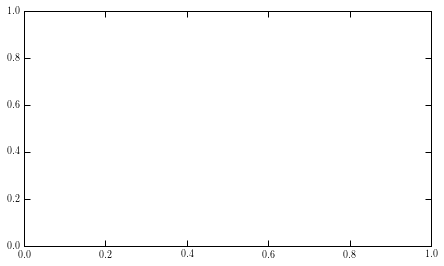

In [10]:
# figFs, axFs = plt.subplots(1,1)

crabSpectrum = 9.10e-9 * (Energies_MeV/118.)**(-2.93) # Fit from Nolan, et al. SpJ 409, 697-704, 1993

galCore = np.array([9.70685e-06,6.85838e-06,3.52933e-06,4.20703e-06,2.56855e-06,1.90188e-06,1.50684e-06,1.21618e-06,9.47592e-07,7.21308e-07,4.77591e-07,3.33494e-07,2.58780e-07,1.93096e-07,1.40246e-07,1.02001e-07,6.42631e-08,4.21583e-08,2.82303e-08,1.67075e-08,1.07388e-08,5.88882e-09,3.44384e-09,2.02983e-09,1.33744e-09,6.65163e-10,2.88258e-10,5.13171e-11,4.63794e-12])
galCoreError = np.array([3.47842e-06,2.47786e-06,9.76928e-07,7.06234e-07,5.59932e-08,4.04776e-08,2.89241e-08,3.07217e-08,2.83946e-08,1.03603e-08,1.23135e-08,1.41791e-08,4.21084e-09,4.85148e-09,4.90537e-09,1.44235e-09,1.82342e-09,1.96727e-09,4.28564e-10,5.69238e-10,6.36344e-10,1.20477e-10,1.64906e-10,1.92826e-10,3.03451e-11,3.21074e-11,4.33015e-11,3.68131e-12,1.16524e-12])
galCoreEnergyRange = np.array([30.,40.,50.,60.,70.,80.,100.,115.,130.,150.,200.,250.,300.,360.,420.,500.,650.,800.,1000.,1300.,1600.,2000.,2600.,3200.,4000.,5000.,7000.,10000.,30000.])

galCoreEnergyRangeSupp = Energies_MeV[:20] # Supplement the energies not included in Hunter et. al 1997
galCoreSupp = 30.*10**(-4)*(galCoreEnergyRangeSupp**(-1.65))
galCoreEnergyRange = np.append(galCoreEnergyRangeSupp,galCoreEnergyRange)
galCore = np.append(galCoreSupp,galCore)

galCoreEnergyRange = np.insert(galCoreEnergyRange, [26], [90.])
galCoreEnergyRange = np.insert(galCoreEnergyRange, [35], [400.0])
galCoreEnergyRange = np.insert(galCoreEnergyRange, [38], [600.0])
galCoreEnergyRange = np.insert(galCoreEnergyRange, [40], [700.0])
galCoreEnergyRange = np.insert(galCoreEnergyRange, [42], [900.0])
galCore = np.insert(galCore, [26], [30.*10**(-4)*(galCoreEnergyRange[26]**(-1.65))])
galCore = np.insert(galCore, [35], [30.*10**(-4)*(galCoreEnergyRange[35]**(-1.65))])
galCore = np.insert(galCore, [38], [30.*10**(-4)*(galCoreEnergyRange[38]**(-1.65))])
galCore = np.insert(galCore, [40], [30.*10**(-4)*(galCoreEnergyRange[40]**(-1.65))])
galCore = np.insert(galCore, [42], [30.*10**(-4)*(galCoreEnergyRange[42]**(-1.65))])

# plt.loglog(Energies_MeV,crabSpectrum,'kx:',label='Crab Nebula')
# plt.loglog(galCoreEnergyRange,galCore,color='purple',marker='s',label='Galactic Core')
# plt.loglog(Energies_MeV,ETFlux, 'rd--', label='Galactic Diffuse')

# # Figure Properties
# axFs.set_ylabel(r'Differential Gamma-ray Flux (ph s$^{-1}$ cm$^{-2}$ sr$^{-1}$ MeV$^{-1}$)')  
# axFs.set_xlabel('Incident Photon Energy (MeV)')
# axFs.set_xlim(1e0,1e3)
# axFs.set_ylim(1e-11,1e-1)

# axFs.legend(loc='upper right')

# # Save the figure 
# file_figFs = 'Source_Fluxes.pdf'
# plt.savefig(DataFolder + file_figFs, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figFs)

In [11]:
# ##########################################################################################
# # Spectrum of vertically downward and upward secondary gamma rays from Schonfelder et al 1980. Adjusted for 2.5 g cm^-2
# figAtm, axAtm = plt.subplots(1,1)

# vertDownSpectrum = (2.5/3.8)*1.e-4*((250*(Energies_MeV**-1.7))+((1.14e5)*(Energies_MeV**-2.5)*np.exp(-(Energies_MeV/120.)**-1.5)))
# vertUpSpectrum = np.array([])
# for i in range(0,len(Energies_MeV)):
#     if Energies_MeV[i] <=20:
#         spectrumValue = 1.e-4*1010.*(Energies_MeV[i]**-1.34)
#         vertUpSpectrum = np.append(vertUpSpectrum,spectrumValue)
#     else:
#         spectrumValue = 1.e-4*7290.*(Energies_MeV[i]**-2)
#         vertUpSpectrum = np.append(vertUpSpectrum,spectrumValue)
# plt.loglog(Energies_MeV,vertUpSpectrum, color='orange', marker='^',label='Vertically Upward Secondary')
# plt.loglog(Energies_MeV,vertDownSpectrum, 'gp-',label='Vertically Downward Secondary')

# # Figure Properties
# axAtm.set_ylabel(r'Differential Gamma-ray Flux (ph s$^{-1}$ cm$^{-2}$ sr$^{-1}$ MeV$^{-1}$)')  
# axAtm.set_xlabel('Incident Photon Energy (MeV)')
# axAtm.set_xlim(1e0,1e3)
# axAtm.set_ylim(1e-7,2e-1)

# axAtm.legend(loc='upper right')

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/All_Source_Fluxes.pdf


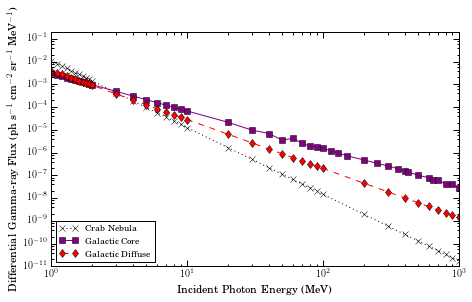

In [12]:
figAll, axAll = plt.subplots(1,1)

plt.loglog(Energies_MeV,crabSpectrum,'kx:',label='Crab Nebula')
plt.loglog(galCoreEnergyRange,galCore,color='purple',marker='s',label='Galactic Core')
plt.loglog(Energies_MeV,ETFlux, 'rd--', label='Galactic Diffuse')
# plt.loglog(Energies_MeV,vertUpSpectrum, color='orange', marker='^',label='Vertically Upward Secondary')
# plt.loglog(Energies_MeV,vertDownSpectrum, 'gp-',label='Vertically Downward Secondary')

# Figure Properties
axAll.set_ylabel(r'Differential Gamma-ray Flux (ph s$^{-1}$ cm$^{-2}$ sr$^{-1}$ MeV$^{-1}$)')  
axAll.set_xlabel('Incident Photon Energy (MeV)')
axAll.set_xlim(1e0,1e3)
axAll.set_ylim(1e-11,2e-1)

axAll.legend(loc='lower left')

# Save the figure 
file_figAll = 'All_Source_Fluxes.pdf'
plt.savefig(DataFolder + file_figAll, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figAll)

In [13]:
##########################################################################################
# Compute the Differential and Integral Count Rates for Crab

diffCountRateCrab = G_Pair*crabSpectrum  # Differential count rate

###################
# Simspn's/trapezoidal

Counts = 0
dE = 0
intCountRateCrab_Trap = np.array([])

for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
    dE = Energies_MeV[i+1]-Energies_MeV[i]
    Counts = trapz(diffCountRateCrab[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRateCrab_Trap = np.append(intCountRateCrab_Trap,Counts)
    
intCountRateCrab_Trap = sum(intCountRateCrab_Trap)

###################
# Average energy method

def effEnergy(Energy1,Energy2):
    effEnergy1 = np.log(Energy2/Energy1)/(1./Energy1-1./Energy2)
    effEnergy2 = 1./((effEnergy1**2)*(1./Energy1-1./Energy2))
    return effEnergy1,effEnergy2    # effEnergy1 = 1./(<E>^2 * (1/E1 - 1/E2))

counts = 0
inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

[effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

diffCountRateCrab1 = diffCountRateCrab[0:len(effecEnergy2)]/effecEnergy2
revdiffCountRateCrab1 = diffCountRateCrab1[::-1]
intCountRateCrab_Avg = np.array([])

for i in range(0,len(diffCountRateCrab)):
    counts = sum(revdiffCountRateCrab1[0:i])
    intCountRateCrab_Avg = np.append(intCountRateCrab_Avg, counts)
    
intCountRateCrab_Avg = intCountRateCrab_Avg[::-1]

##########################################################################################
# # Plot the differential count rate
# figD, axD = plt.subplots(1,1)
# plt.loglog(Energies_MeV,diffCountRateCrab,'kx-')
# plt.loglog(Energies_MeV,G_Pair,'b.-')

# axD.set_ylabel(r'Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
# axD.set_xlabel('Incident Photon Energy (MeV)')
# # axD.set_ylim(1e-9, 1e-4)
# axD.set_xlim(1, 1000)

# plt.tight_layout()

# file_figD = 'Differential_Count_Rate_Crab.pdf'
# plt.savefig(DataFolder + file_figD, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figD)

# plt.show(figD)


# ##########################################################################################
# # Plot the Integral Count Rate
# figI, axI = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)],intCountRateCrab_Avg,'kx-')

# # Figure Properties
# axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$) with Energy $>$ E')  
# axI.set_xlabel('Incident Photon Energy (MeV)') 
# axI.set_ylim(1e-7, 1e-3)
# axI.set_xlim(1e-2, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figI = 'Integral_Count_Rate_Crab.pdf'
# plt.savefig(DataFolder + file_figI, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figI)

# # Show the figure
# plt.show(figI)

##########################################################################################
print "Predicted count rate of", max(intCountRateCrab_Avg)*2700#, "+/- ", intCountRateErrorAvg*60*92.6318, "counts/orbit by Average Energy Method."
print "Predicted count rate of", intCountRateCrab_Trap*2700#," +/- ", intCountRateError*60*92.6318, "counts/orbit by Modified Simpson's Rule."
print "Predicted count rate of", max(intCountRateCrab_Avg)*60*60*24*365/2#, +/- ", intCountRateErrorAvg*60*60*24*365, "counts/year by Average Energy Method."
print "Predicted count rate of", intCountRateCrab_Trap*60*60*24*365/2#, " +/- ", intCountRateError*60*60*24*365, "counts/year by Modified Simpson's Rule."

Predicted count rate of 1.93633210193
Predicted count rate of 1.63131869164
Predicted count rate of 11308.1794753
Predicted count rate of 9526.90115915


Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/Differential_Count_Rate_Core.pdf


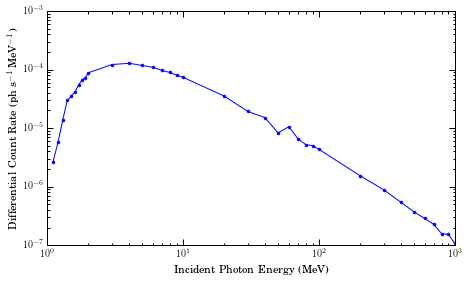

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/Integral_Count_Rate_Core.pdf


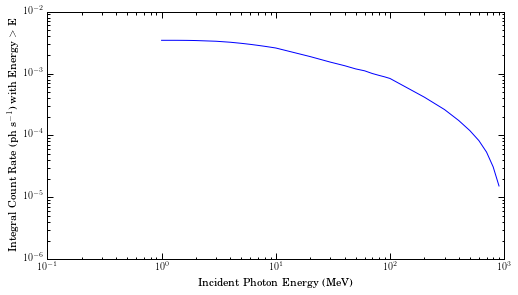

Predicted count rate of 12.0893590273
Predicted count rate of 10.3303288027
Predicted count rate of 54309.1205536
Predicted count rate of 46407.0155443


In [14]:
##########################################################################################
# Compute the Differential and Integral Count Rates for the Galactic Core
# diffCountRateCore = G_Pair*galCore  # Differential count rate
acceptedEnergy = np.array([])
diffCountRateCore = np.array([])

for i in range(0,len(galCoreEnergyRange)):
    for j in range(0,len(Energies_MeV)):
        if galCoreEnergyRange[i] == Energies_MeV[j]:
            diffCountRateCore = np.append(diffCountRateCore,G_Pair[j] * galCore[i])
            acceptedEnergy = np.append(acceptedEnergy,galCoreEnergyRange[i])
#             print galCoreEnergyRange[i], diffCountRateCore[accept]

###################
# Simspn's/trapezoidal

Counts = 0
dE = 0
intCountRateCore_Trap = np.array([])

for i in range(0,len(acceptedEnergy)-1):    # Modified Simpson's rule with variable energy spacing
    dE = acceptedEnergy[i+1]-acceptedEnergy[i]
    Counts = trapz(diffCountRateCore[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
    intCountRateCore_Trap = np.append(intCountRateCore_Trap,Counts)
    
intCountRateCore_Trap = sum(intCountRateCore_Trap)

###################
# Average energy method

def effEnergy(Energy1,Energy2):
    effEnergy1 = np.log(Energy2/Energy1)/(1./Energy1-1./Energy2)
    effEnergy2 = 1./((effEnergy1**2)*(1./Energy1-1./Energy2))
    return effEnergy1,effEnergy2    # effEnergy1 = 1./(<E>^2 * (1/E1 - 1/E2))

counts = 0
inEnergy1 = 1.*acceptedEnergy[0:len(acceptedEnergy)-1]
inEnergy2 = 1.*acceptedEnergy[1:len(acceptedEnergy)]

[effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

diffCountRateCore1 = diffCountRateCore[0:len(effecEnergy2)]/effecEnergy2
revdiffCountRateCore1 = diffCountRateCore1[::-1]
intCountRateCore_Avg = np.array([])

for i in range(0,len(diffCountRateCore)):
    counts = sum(revdiffCountRateCore1[0:i])
    intCountRateCore_Avg = np.append(intCountRateCore_Avg, counts)
    
intCountRateCore_Avg = intCountRateCore_Avg[::-1]

##########################################################################################
# Plot the differential count rate
figD, axD = plt.subplots(1,1)
# plt.loglog(Energies_MeV,diffCountRateCore,'b-')
plt.loglog(acceptedEnergy,diffCountRateCore,'b.-')

axD.set_ylabel(r'Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
axD.set_xlabel('Incident Photon Energy (MeV)')
# # axD.set_ylim(1e-9, 1e-4)
axD.set_xlim(1, 1000)

# plt.tight_layout()

file_figD = 'Differential_Count_Rate_Core.pdf'
plt.savefig(DataFolder + file_figD, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figD)

plt.show(figD)


# ##########################################################################################
# Plot the Integral Count Rate
figI, axI = plt.subplots(1,1)
plt.loglog(Energies_MeV[:len(Energies_MeV)],intCountRateCore_Avg,'b-')

# Figure Properties
axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$) with Energy $>$ E')  
axI.set_xlabel('Incident Photon Energy (MeV)') 
axI.set_ylim(1e-6, 1e-2)
axI.set_xlim(1e-1, 1000)

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figI = 'Integral_Count_Rate_Core.pdf'
plt.savefig(DataFolder + file_figI, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figI)

# Show the figure
plt.show(figI)


##########################################################################################
print "Predicted count rate of", max(intCountRateCore_Avg)*5400*0.65#, "+/- ", intCountRateErrorAvg*60*92.6318, "counts/orbit by Average Energy Method."
print "Predicted count rate of", intCountRateCore_Trap*5400*0.65#," +/- ", intCountRateError*60*92.6318, "counts/orbit by Modified Simpson's Rule."
print "Predicted count rate of", max(intCountRateCore_Avg)*60*60*24*365/2#, +/- ", intCountRateErrorAvg*60*60*24*365, "counts/year by Average Energy Method."
print "Predicted count rate of", intCountRateCore_Trap*60*60*24*365/2#, " +/- ", intCountRateError*60*60*24*365, "counts/year by Modified Simpson's Rule."

In [15]:
# ##########################################################################################
# # Compute the Differential and Integral Count Rates for Vertically Downward Secondaries

# diffCountRateDownward = G_Pair*vertDownSpectrum  # Differential count rate

# ###################
# # Simspn's/trapezoidal

# Counts = 0
# dE = 0
# intCountRateDownward_Trap = np.array([])

# for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
#     dE = Energies_MeV[i+1]-Energies_MeV[i]
#     Counts = trapz(diffCountRateDownward[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
#     intCountRateDownward_Trap = np.append(intCountRateDownward_Trap,Counts)
    
# intCountRateDownward_Trap = sum(intCountRateDownward_Trap)

# ###################
# # Average energy method

# def effEnergy(Energy1,Energy2):
#     effEnergy1 = np.log(Energy2/Energy1)/(1./Energy1-1./Energy2)
#     effEnergy2 = 1./((effEnergy1**2)*(1./Energy1-1./Energy2))
#     return effEnergy1,effEnergy2    # effEnergy1 = 1./(<E>^2 * (1/E1 - 1/E2))

# counts = 0
# inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
# inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

# [effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

# diffCountRateDownward1 = diffCountRateDownward[0:len(effecEnergy2)]/effecEnergy2
# revdiffCountRateDownward1 = diffCountRateDownward1[::-1]
# intCountRateDownward_Avg = np.array([])

# for i in range(0,len(diffCountRateDownward)):
#     counts = sum(revdiffCountRateDownward1[0:i])
#     intCountRateDownward_Avg = np.append(intCountRateDownward_Avg, counts)
    
# intCountRateDownward_Avg = intCountRateDownward_Avg[::-1]

# ##########################################################################################
# # Plot the differential count rate
# figD, axD = plt.subplots(1,1)
# plt.loglog(Energies_MeV,diffCountRateDownward,'gp-')
# plt.loglog(Energies_MeV,G_Pair,'b.-')

# axD.set_ylabel(r'Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
# axD.set_xlabel('Incident Photon Energy (MeV)')
# # axD.set_ylim(1e-9, 1e-4)
# axD.set_xlim(1, 1000)

# plt.tight_layout()

# file_figD = 'Differential_Count_Rate_Downward.pdf'
# plt.savefig(DataFolder + file_figD, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figD)

# plt.show(figD)


# ##########################################################################################
# # Plot the Integral Count Rate
# figI, axI = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)],intCountRateDownward_Avg,'gp-')

# # Figure Properties
# axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$) with Energy $>$ E')  
# axI.set_xlabel('Incident Photon Energy (MeV)') 
# # axI.set_ylim(1e-7, 1e-3)
# axI.set_xlim(1e-1, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figI = 'Integral_Count_Rate_Downward.pdf'
# plt.savefig(DataFolder + file_figI, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figI)

# # Show the figure
# plt.show(figI)

# ##########################################################################################
# print "Predicted count rate of", max(intCountRateDownward_Avg)*5400#, "+/- ", intCountRateErrorAvg*60*92.6318, "counts/orbit by Average Energy Method."
# print "Predicted count rate of", intCountRateDownward_Trap*5400#," +/- ", intCountRateError*60*92.6318, "counts/orbit by Modified Simpson's Rule."
# print "Predicted count rate of", max(intCountRateDownward_Avg)*60*60*24*365/2#, +/- ", intCountRateErrorAvg*60*60*24*365, "counts/year by Average Energy Method."
# print "Predicted count rate of", intCountRateDownward_Trap*60*60*24*365/2#, " +/- ", intCountRateError*60*60*24*365, "counts/year by Modified Simpson's Rule."

In [16]:
# ##########################################################################################
# # Compute the Differential and Integral Count Rates for Vertically Upward Secondaries

# diffCountRateUpward = G_Pair*vertUpSpectrum  # Differential count rate

# ###################
# # Simspn's/trapezoidal

# Counts = 0
# dE = 0
# intCountRateUpward_Trap = np.array([])

# for i in range(0,len(InputEnergies)-1):    # Modified Simpson's rule with variable energy spacing
#     dE = Energies_MeV[i+1]-Energies_MeV[i]
#     Counts = trapz(diffCountRateUpward[i:i+2],dx=dE)# Energies_MeV[i:i+2])# # Using dE or Energies_MeV gives the same answer
#     intCountRateUpward_Trap = np.append(intCountRateUpward_Trap,Counts)
    
# intCountRateUpward_Trap = sum(intCountRateUpward_Trap)

# ###################
# # Average energy method

# def effEnergy(Energy1,Energy2):
#     effEnergy1 = np.log(Energy2/Energy1)/(1./Energy1-1./Energy2)
#     effEnergy2 = 1./((effEnergy1**2)*(1./Energy1-1./Energy2))
#     return effEnergy1,effEnergy2    # effEnergy1 = 1./(<E>^2 * (1/E1 - 1/E2))

# counts = 0
# inEnergy1 = 1.*Energies_MeV[0:len(Energies_MeV)-1]
# inEnergy2 = 1.*Energies_MeV[1:len(Energies_MeV)]

# [effecEnergy1,effecEnergy2] = effEnergy(inEnergy1,inEnergy2)    # <E>

# diffCountRateUpward1 = diffCountRateUpward[0:len(effecEnergy2)]/effecEnergy2
# revdiffCountRateUpward1 = diffCountRateUpward1[::-1]
# intCountRateUpward_Avg = np.array([])

# for i in range(0,len(diffCountRateUpward)):
#     counts = sum(revdiffCountRateUpward1[0:i])
#     intCountRateUpward_Avg = np.append(intCountRateUpward_Avg, counts)
    
# intCountRateUpward_Avg = intCountRateUpward_Avg[::-1]

# ##########################################################################################
# # Plot the differential count rate
# figD, axD = plt.subplots(1,1)
# plt.loglog(Energies_MeV,diffCountRateUpward,color='orange',marker='^')
# plt.loglog(Energies_MeV,G_Pair,'b.-')

# axD.set_ylabel(r'Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
# axD.set_xlabel('Incident Photon Energy (MeV)')
# # axD.set_ylim(1e-9, 1e-4)
# axD.set_xlim(1, 1000)

# plt.tight_layout()

# file_figD = 'Differential_Count_Rate_Upward.pdf'
# plt.savefig(DataFolder + file_figD, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figD)

# plt.show(figD)


# ##########################################################################################
# # Plot the Integral Count Rate
# figI, axI = plt.subplots(1,1)
# plt.loglog(Energies_MeV[:len(Energies_MeV)],intCountRateUpward_Avg,color='orange',marker='^')

# # Figure Properties
# axI.set_ylabel(r'Integral Count Rate (ph s$^{-1}$) with Energy $>$ E')  
# axI.set_xlabel('Incident Photon Energy (MeV)') 
# # axI.set_ylim(1e-7, 1e-3)
# axI.set_xlim(1e-2, 1000)

# # Tight Layout
# plt.tight_layout()

# # Save the figure 
# file_figI = 'Integral_Count_Rate_Upward.pdf'
# plt.savefig(DataFolder + file_figI, bbox_inches="tight")
# print 'Plot saved to: ' + (DataFolder+file_figI)

# # Show the figure
# plt.show(figI)

# ##########################################################################################
# print "Predicted count rate of", max(intCountRateUpward_Avg)*5400#, "+/- ", intCountRateErrorAvg*60*92.6318, "counts/orbit by Average Energy Method."
# print "Predicted count rate of", intCountRateUpward_Trap*5400#," +/- ", intCountRateError*60*92.6318, "counts/orbit by Modified Simpson's Rule."
# print "Predicted count rate of", max(intCountRateUpward_Avg)*60*60*24*365/2#, +/- ", intCountRateErrorAvg*60*60*24*365, "counts/year by Average Energy Method."
# print "Predicted count rate of", intCountRateUpward_Trap*60*60*24*365/2#, " +/- ", intCountRateError*60*60*24*365, "counts/year by Modified Simpson's Rule."

 Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/Differential_Count_Rate_All_4U.pdf


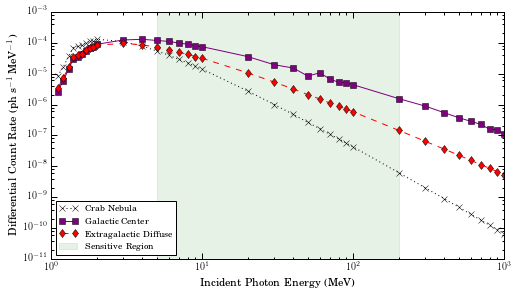

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gamma_4U_Rev2/Integral_Count_Rate_All_4U.pdf


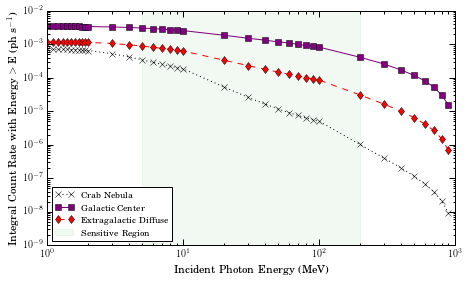

500.0
1.16925448247e-07 0.000119845419926 6.55134156532e-06

NameError: name 'intCountRateDownward_Avg' is not defined

In [22]:
##########################################################################################
# Plot the differential count rates
figD, axD = plt.subplots()
plot1 = axD.loglog(Energies_MeV,diffCountRateCrab,'kx:',label='Crab Nebula')
plot2 = axD.loglog(acceptedEnergy,diffCountRateCore,color='purple',marker='s',label='Galactic Center')
plot3 = axD.loglog(Energies_MeV,diffCountRate, 'rd--', label='Extragalactic Diffuse')
# plot4 = axD.loglog(Energies_MeV,diffCountRateDownward, 'gp-',label='Downward Atmoshperic Secondary')
# plot5 = axD.loglog(Energies_MeV,diffCountRateUpward, color='orange',marker='^',label='Upward Atmoshperic Secondary')

axD.set_ylabel(r'Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
axD.set_xlabel('Incident Photon Energy (MeV)')
axD.set_ylim(1e-11, 1e-3)
axD.set_xlim(1, 1000)
axD.fill_between([5,200], 1e-11, 1e2, color='green', alpha=0.1, label='Sensitive Region')

# ax1 = axD.twinx()
# plot4 = ax1.loglog(Energies_MeV,G_Pair,'b-',label='Geometric Factor')
# ax1.set_xlabel('Incident Gamma Energy (MeV)')
# ax1.set_ylabel('Geometric Factor (cm$^2$ sr)')
# ax1.yaxis.label.set_color('blue')
# ax1.tick_params(which='major',axis='y', colors='blue')
# ax1.tick_params(which='minor',axis='y', colors='blue')
# ax1.spines['right'].set_color('blue')
# ax1.set_xlim(1, 1e3)
# ax1.set_ylim(1e-4, 2e0)

# PLOT = plot1+plot2+plot3
# labs = [l.get_label() for l in PLOT]
axD.legend(loc='lower left')

plt.tight_layout()

file_figD = 'Differential_Count_Rate_All_4U.pdf'
plt.savefig(DataFolder + file_figD, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figD)

plt.show(figD)

##########################################################################################
# Plot the integral count rates
intCountRateTotal = np.array([])
for i in range(0,len(intCountRate1)):
    if acceptedEnergy[i]==Energies_MeV[i]:
        intCountRateTotal = np.append(intCountRateTotal,intCountRateCrab_Avg[i]+intCountRateCore_Avg[i]+intCountRate1[i])
    else:
        intCountRateTotal = np.append(intCountRateTotal,intCountRateCrab_Avg[i]+intCountRate1[i])
        print 'True'

figI, axI = plt.subplots()
plotI1 = axI.loglog(Energies_MeV,intCountRateCrab_Avg,'kx:',label='Crab Nebula')
plotI2 = axI.loglog(acceptedEnergy,intCountRateCore_Avg,color='purple',marker='s',label='Galactic Center')
plotI3 = axI.loglog(Energies_MeV,intCountRate1, 'rd--', label='Extragalactic Diffuse')
# plotI4 = axI.loglog(Energies_MeV,intCountRateTotal, color='cyan',marker='o',label='Total')
# plotI5 = axI.loglog(Energies_MeV,intCountRateDownward_Avg,'gp-',label='Downward Atmospheric Seondary')
# plotI6 = axI.loglog(Energies_MeV,intCountRateUpward_Avg,color='orange',marker='^',label='Upward Atmospheric Seondary')

axI.set_ylabel(r'Integral Count Rate with Energy $>$ E (ph s$^{-1}$)')
axI.set_xlabel('Incident Photon Energy (MeV)')
axI.set_ylim(1e-9, 1e-2)
axI.set_xlim(1, 1000)
axI.fill_between([5,200], 1e-11, 1e0, color='green', alpha=0.05, label='Sensitive Region')

axI.legend(loc='lower left')

file_figI = 'Integral_Count_Rate_All_4U.pdf'
plt.savefig(DataFolder + file_figI, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figI)

plt.show(figI)
print Energies_MeV[31]
print intCountRateCrab_Avg[31], intCountRateCore_Avg[31], intCountRate1[31],intCountRateDownward_Avg[31]
print "Total instrument count rate:", max(intCountRateCore_Avg)*5400*0.65+max(intCountRateCrab_Avg)*2700+max(intCountRate1)*5400,' counts/orbit'

In [ ]:
fig, ax1 = plt.subplots()
plot1 = ax1.loglog(Energies_MeV,G_Pair,'b-',label='Geometric Factor')
ax1.set_xlabel('Incident Gamma Energy (MeV)')
ax1.set_ylabel('Geometric Factor (cm$^2$ sr)')
ax1.yaxis.label.set_color('blue')
ax1.tick_params(which='major',axis='y', colors='blue')
ax1.tick_params(which='minor',axis='y', colors='blue')
ax1.set_xlim(1, 1e3)
ax1.set_ylim(1e-4, 2e0)

ax2 = ax1.twinx()
plot2 = ax2.loglog(Energies_MeV,diffCountRate,'r--',label='Differential Count Rate')
ax2.set_ylabel('Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
ax2.yaxis.label.set_color('red')
ax2.tick_params(which='minor',axis='y', colors='red')
ax2.tick_params(which='major',axis='y', colors='red')
ax2.set_xlim(1, 1e3)
ax2.set_ylim(1e-9, 2e-4)

plott = plot1+plot2
labs = [l.get_label() for l in plott]
ax1.legend(plott, labs, loc='upper left')

# Save the figure 
file_fig = 'Geometric_Factor_diffCount_Gamma_Diffuse.pdf'
plt.savefig(DataFolder + file_fig, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_fig)

plt.show()

In [ ]:
fig, ax1 = plt.subplots()
plot1 = ax1.loglog(Energies_MeV,G_Pair,'b-',label='Geometric Factor')
ax1.set_xlabel('Incident Gamma Energy (MeV)')
ax1.set_ylabel('Geometric Factor (cm$^2$ sr)')
ax1.yaxis.label.set_color('blue')
ax1.tick_params(which='major', axis='y', colors='blue')
ax1.tick_params(which='minor', axis='y', colors='blue')
ax1.set_xlim(1, 1e3)
ax1.set_ylim(1e-4, 2e0)

ax2 = ax1.twinx()
plot2 = ax2.loglog(Energies_MeV,diffCountRateCrab,'k--',label='Differential Count Rate')
ax2.set_ylabel('Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
ax2.yaxis.label.set_color('black')
ax2.tick_params(which='major', axis='y', colors='black')
ax2.tick_params(which='minor', axis='y', colors='black')
ax2.set_xlim(1, 1e3)
ax2.set_ylim(1e-9, 2e-4)

plott = plot1+plot2
labs = [l.get_label() for l in plott]
ax1.legend(plott, labs, loc='upper left')

# Save the figure 
file_fig = 'Geometric_Factor_diffCount_Gamma_Crab.pdf'
plt.savefig(DataFolder + file_fig, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_fig)

plt.show()

In [ ]:
fig, ax1 = plt.subplots()
plot1 = ax1.loglog(Energies_MeV,G_Pair,'b-',label='Geometric Factor')
ax1.set_xlabel('Incident Gamma Energy (MeV)')
ax1.set_ylabel('Geometric Factor (cm$^2$ sr)')
ax1.yaxis.label.set_color('blue')
ax2.tick_params(which='major', axis='y', colors='blue')
ax2.tick_params(which='minor', axis='y', colors='blue')
ax1.set_xlim(1, 1e3)
ax1.set_ylim(1e-4, 2e0)

ax2 = ax1.twinx()
plot2 = ax2.loglog(acceptedEnergy,diffCountRateCore,color='purple',linestyle='dashed',label='Differential Count Rate')
ax2.set_ylabel('Differential Count Rate (ph s$^{-1}$ MeV$^{-1}$)')
ax2.yaxis.label.set_color('purple')
ax2.tick_params(which='major', axis='y', colors='purple')
ax2.tick_params(which='minor', axis='y', colors='purple')
ax2.set_xlim(1, 1e3)
ax2.set_ylim(1e-9, 2e-4)

plott = plot1+plot2
labs = [l.get_label() for l in plott]
ax1.legend(plott, labs, loc='upper left')

# Save the figure 
file_fig = 'Geometric_Factor_diffCount_Gamma_Core.pdf'
plt.savefig(DataFolder + file_fig, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_fig)

plt.show()

Plot saved to: ../G4AdEPTCubeSat_Results/Ar+CS2/Gammas/Effective_Area_Gamma.pdf


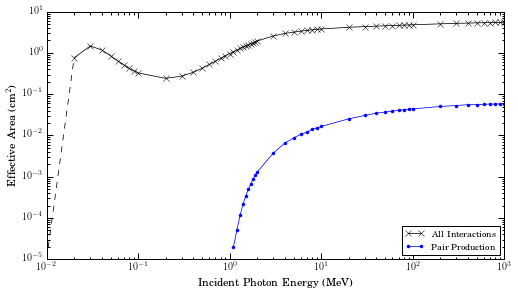

In [20]:
##########################################################################################
# Instrument Effective Area

Aeff_Pair = G_Pair/(4.*np.pi)
Aeff_Total = G_Total/(4.*np.pi)
Aeff_Total[0] = 1e-6

figAeff, axAeff = plt.subplots(1,1)
dropOff = [1e-5, Aeff_Total[1]]

plt.loglog(Data[1:,0]/1000., Aeff_Total[1:], 'kx-', linewidth=0.75, label='All Interactions')
plt.loglog(Data[0:2,0]/1000., dropOff, 'k--', linewidth=0.75)
plt.loglog(Data[:,0]/1000., Aeff_Pair, 'b.-', linewidth=0.75, label="Pair Production")

# Figure Properties
axAeff.set_ylabel(r'Effective Area (cm$^2$)')  
axAeff.set_xlabel('Incident Photon Energy (MeV)') 
axAeff.set_ylim(1e-5, 1e1)
axAeff.set_xlim(1e-2, 1000)

axAeff.legend(loc='lower right')

# Tight Layout
plt.tight_layout()

# Save the figure 
file_figAeff = 'Effective_Area_Gamma.pdf'
plt.savefig(DataFolder + file_figAeff, bbox_inches="tight")
print 'Plot saved to: ' + (DataFolder+file_figAeff)

# Show the figure
plt.show(figG)